<a href="https://colab.research.google.com/github/pmlaleoro/CNN-Breast-Tissue-Classification/blob/main/Breast_Tissue_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **"Classification of Breast Tissue Images Using Convolutional Neural Networks (CNN)"**

Presented By:



*   Leoro, Pamela Angel







A previously developed model using an Artificial Neural Network (ANN) (refer on the Lesson 2 Activity) has demonstrated the feasibility of classifying breast tissue images; however, its performance is limited due to the network’s inability to fully capture spatial relationships and local morphological features within high-resolution images. ANNs process images as one-dimensional vectors, which results in the loss of critical structural information necessary for distinguishing subtle variations between tissue types. Convolutional Neural Networks (CNNs), in contrast, are specifically designed to handle image data by preserving spatial hierarchies through convolutional and pooling layers, enabling the automatic extraction of both low-level and high-level features. By leveraging these capabilities, CNNs offer a more accurate and robust approach for the classification of breast tissue images compared to traditional ANN models.

---



# **STEP 1: DATA ACQUISITION**

Data acquisition involves collecting breast tissue images from the BreakHis dataset available on Kaggle. The dataset contains high-resolution histopathological images categorized as benign or malignant, with multiple magnifications for each tissue sample. The images are organized into separate folders to facilitate model training. This step ensures that a well-labeled and diverse dataset is available for the CNN to learn meaningful features.

---



**Setting Up Kaggle API in Colab**

In [ ]:
from google.colab import files
import os
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Downloading the BreakHis DataSet**

In [ ]:
import zipfile

!kaggle datasets download -d ambarish/breakhis --force
with zipfile.ZipFile("breakhis.zip", "r") as zip_ref:
    zip_ref.extractall("breakhis_dataset")

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
100% 3.97G/3.99G [01:07<00:01, 13.5MB/s]
100% 3.99G/3.99G [01:07<00:00, 63.2MB/s]


**Creating a simplified benign and malignant folders**

In [ ]:
import shutil
import os

base_folder = "breakhis_dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
benign_source = os.path.join(base_folder, "benign")
malignant_source = os.path.join(base_folder, "malignant")
target_benign = "breakhis_dataset/benign"
target_malignant = "breakhis_dataset/malignant"
os.makedirs(target_benign, exist_ok=True)
os.makedirs(target_malignant, exist_ok=True)

def copy_images(source_folder, target_folder):
    for root, dirs, files in os.walk(source_folder):
        for f in files:
            if f.lower().endswith(".png"):
                shutil.copy(os.path.join(root, f), os.path.join(target_folder, f))

copy_images(benign_source, target_benign)
copy_images(malignant_source, target_malignant)

print(os.path.abspath(target_benign))
print(os.path.abspath(target_malignant))


/content/breakhis_dataset/benign
/content/breakhis_dataset/malignant


# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**

EDA examines the dataset to understand the characteristics and distribution of images. It includes checking class balance, image dimensions, pixel intensity distributions, and visualizing sample images. Insights from this analysis guide preprocessing and model design by identifying inconsistencies, variations in magnification, and any potential biases in the dataset.

---



**Checking Class Distribution**

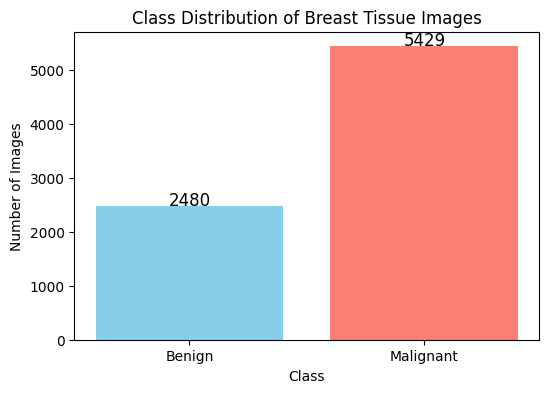

In [ ]:
import os
import matplotlib.pyplot as plt

benign_folder = "breakhis_dataset/benign"
malignant_folder = "breakhis_dataset/malignant"

num_benign = len([f for f in os.listdir(benign_folder) if f.lower().endswith(".png")])
num_malignant = len([f for f in os.listdir(malignant_folder) if f.lower().endswith(".png")])

class_names = ["Benign", "Malignant"]
counts = [num_benign, num_malignant]

plt.figure(figsize=(6,4))
plt.bar(class_names, counts, color=['skyblue', 'salmon'])
plt.title("Class Distribution of Breast Tissue Images")
plt.xlabel("Class")
plt.ylabel("Number of Images")
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)
plt.show()


**Checking the dimensions of the images**

In [ ]:
from PIL import Image
import numpy as np

sample_images = [os.path.join(benign_folder, f) for f in os.listdir(benign_folder)[:5]] + \
                [os.path.join(malignant_folder, f) for f in os.listdir(malignant_folder)[:5]]

for img_path in sample_images:
    img = Image.open(img_path)
    print(f"{os.path.basename(img_path)}: {img.size}")  # prints (width, height)


SOB_B_F-14-21998EF-200-019.png: (700, 460)
SOB_B_PT-14-21998AB-200-028.png: (700, 460)
SOB_B_A-14-22549CD-100-033.png: (700, 460)
SOB_B_F-14-14134-400-036.png: (700, 460)
SOB_B_TA-14-16184-200-008.png: (700, 460)
SOB_M_PC-14-19440-100-038.png: (700, 460)
SOB_M_DC-14-13412-200-031.png: (700, 460)
SOB_M_DC-14-4364-200-021.png: (700, 460)
SOB_M_DC-14-2523-400-010.png: (700, 460)
SOB_M_LC-14-16196-200-009.png: (700, 460)


**Sample Images Visualization**

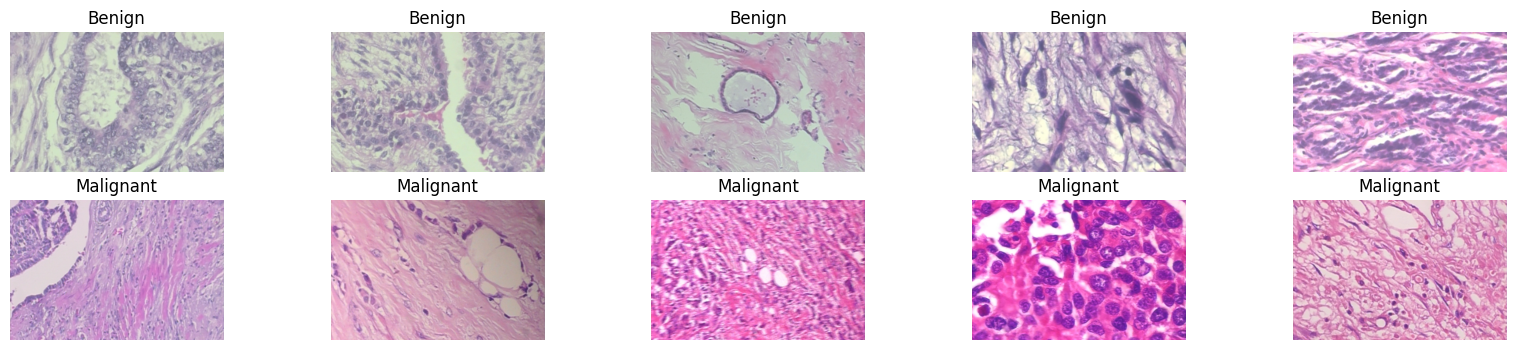

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

benign_folder = "breakhis_dataset/benign"
malignant_folder = "breakhis_dataset/malignant"

def show_images(benign_folder, malignant_folder, n=5):
    benign_files = [f for f in os.listdir(benign_folder) if f.lower().endswith(".png")][:n]
    malignant_files = [f for f in os.listdir(malignant_folder) if f.lower().endswith(".png")][:n]

    plt.figure(figsize=(20, 4))

    for i, f in enumerate(benign_files):
        img = Image.open(os.path.join(benign_folder, f))
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title("Benign")
        plt.axis('off')

    for i, f in enumerate(malignant_files):
        img = Image.open(os.path.join(malignant_folder, f))
        plt.subplot(2, n, n+i+1)
        plt.imshow(img)
        plt.title("Malignant")
        plt.axis('off')

    plt.show()

show_images(benign_folder, malignant_folder, n=5)


**Analyzing Pixel Intensity**

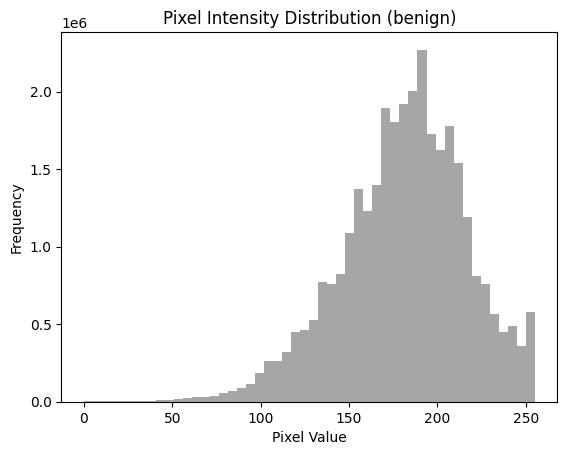

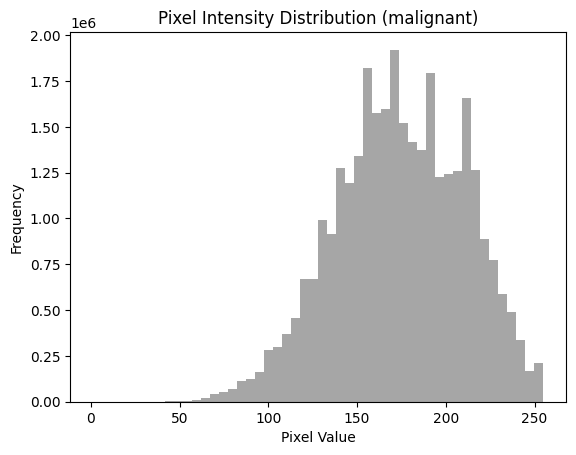

In [ ]:
def pixel_intensity_distribution(folder, n=100):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".png")][:n]
    all_pixels = []
    for f in files:
        img = Image.open(os.path.join(folder, f)).convert('L')  # grayscale
        all_pixels.extend(np.array(img).flatten())
    plt.hist(all_pixels, bins=50, color='gray', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution ({os.path.basename(folder)})")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

pixel_intensity_distribution(benign_folder)
pixel_intensity_distribution(malignant_folder)


# **STEP 3: DATA PREPROCESSING**

Preprocessing prepares the images for CNN training by resizing them to a uniform shape, normalizing pixel values, and applying any necessary color transformations. Additionally, the dataset may be split into training, validation, and test sets, ensuring proper evaluation of the CNN’s performance. Data augmentation techniques, such as rotation, flipping, and zooming, are applied to increase dataset diversity and improve model generalization.

---



**Preprocessing the Images**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMAGE_SIZE = (128, 128)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".png"):
                img_path = os.path.join(root, file)
                img = load_img(img_path, target_size=IMAGE_SIZE)
                img_array = img_to_array(img) / 255.0  # normalize to 0-1
                images.append(img_array)
                labels.append(label)
    return images, labels

benign_folder = "breakhis_dataset/benign"
malignant_folder = "breakhis_dataset/malignant"

benign_images, benign_labels = load_images_from_folder(benign_folder, 0)
malignant_images, malignant_labels = load_images_from_folder(malignant_folder, 1)

X = np.array(benign_images + malignant_images)
y = np.array(benign_labels + malignant_labels)


**Splitting the Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (5536, 128, 128, 3) (5536,)
Validation set: (1186, 128, 128, 3) (1186,)
Test set: (1187, 128, 128, 3) (1187,)


**Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()  # no augmentation for validation/test


# **STEP 4: MODELLING**

The CNN architecture is designed to automatically extract hierarchical features from the images. Convolutional and pooling layers capture local patterns, while fully connected layers perform classification. Techniques like batch normalization and dropout are incorporated to improve convergence and prevent overfitting. The model is trained using labeled images to learn to distinguish between benign and malignant tissue.

---



**Defining the CNN Architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,185 (24.86 MB)

 Trainable params: 6,516,737 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

**Setting Up Callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('Breast-Tissue-Classification_CNN.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]


**Training the Model**

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7479 - loss: 3.0877

173/173 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.7480 - loss: 3.0781 - val_accuracy: 0.6863 - val_loss: 4.8989 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8235 - loss: 0.4231

173/173 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8235 - loss: 0.4232 - val_accuracy: 0.6872 - val_loss: 2.6061 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8137 - loss: 0.4610 - val_accuracy: 0.6880 - val_loss: 9.3636 - learning_rate: 0.0010
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8112 - loss: 0.4509

173/173 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8112 - loss: 0.4507 - val_accuracy: 0.7766 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8270 - loss: 0.3929 - val_accuracy: 0.7437 - val_loss: 0.8053 - learning_rate: 0.0010
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8519 - loss: 0.3597 - val_accuracy: 0.7951 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8483 - loss: 0.3442 - val_accuracy: 0.6830 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8478 - loss: 0.3410 - val_accuracy: 0.6880 - val_loss: 3.2114 - learning_rate: 0.0010
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8563 - loss: 0.3225 - val_accuracy: 0.7572 - val_loss: 0.9464 - learning_rate: 0.0010
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8763 - loss: 0.2804

173/173 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.8762 - loss: 0.2804 - val_accuracy: 0.8204 - val_loss: 0.4239 - learning_rate: 5.0000e-04
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8805 - loss: 0.2531 - val_accuracy: 0.8044 - val_loss: 0.7232 - learning_rate: 5.0000e-04
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8883 - loss: 0.2511 - val_accuracy: 0.7960 - val_loss: 0.4572 - learning_rate: 5.0000e-04
Epoch 13/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8952 - loss: 0.2447

173/173 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8951 - loss: 0.2448 - val_accuracy: 0.8314 - val_loss: 0.3357 - learning_rate: 5.0000e-04
Epoch 14/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8861 - loss: 0.2503

173/173 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8861 - loss: 0.2503 - val_accuracy: 0.8895 - val_loss: 0.2718 - learning_rate: 5.0000e-04
Epoch 15/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8932 - loss: 0.2385 - val_accuracy: 0.7934 - val_loss: 0.6130 - learning_rate: 5.0000e-04
Epoch 16/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.8950 - loss: 0.2397 - val_accuracy: 0.8078 - val_loss: 0.3988 - learning_rate: 5.0000e-04
Epoch 17/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8986 - loss: 0.2533 - val_accuracy: 0.5565 - val_loss: 1.7474 - learning_rate: 5.0000e-04
Epoch 18/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9018 - loss: 0.2461 - val_accuracy: 0.8120 - val_loss: 0.6369 - learning_rate: 5.0000e-04
Epoch 19/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9061 - loss: 0.2127 - val_accuracy: 0.7892 - val_loss: 0.4238 - learning_rate: 5.0000e-04
Epoch 20/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy

173/173 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9160 - loss: 0.1940 - val_accuracy: 0.9089 - val_loss: 0.2502 - learning_rate: 2.5000e-04
Epoch 22/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9150 - loss: 0.2027 - val_accuracy: 0.8305 - val_loss: 0.4345 - learning_rate: 2.5000e-04
Epoch 23/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9258 - loss: 0.1720 - val_accuracy: 0.8255 - val_loss: 0.4109 - learning_rate: 2.5000e-04
Epoch 24/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9213 - loss: 0.1923 - val_accuracy: 0.9207 - val_loss: 0.2760 - learning_rate: 2.5000e-04
Epoch 25/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9206 - loss: 0.1823 - val_accuracy: 0.8634 - val_loss: 0.3638 - learning_rate: 2.5000e-04
Epoch 26/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9181 - loss: 0.1933 - val_accuracy: 0.8541 - val_loss: 0.4176 - learning_rate: 2.5000e-04
Epoch 27/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 

173/173 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9343 - loss: 0.1685 - val_accuracy: 0.9157 - val_loss: 0.2166 - learning_rate: 1.2500e-04
Epoch 28/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9300 - loss: 0.1552 - val_accuracy: 0.8457 - val_loss: 0.3376 - learning_rate: 1.2500e-04
Epoch 29/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9230 - loss: 0.1680 - val_accuracy: 0.8373 - val_loss: 0.5033 - learning_rate: 1.2500e-04
Epoch 30/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9383 - loss: 0.1559 - val_accuracy: 0.9064 - val_loss: 0.2949 - learning_rate: 1.2500e-04
Epoch 31/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9376 - loss: 0.1761 - val_accuracy: 0.9157 - val_loss: 0.2628 - learning_rate: 1.2500e-04
Epoch 32/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9328 - loss: 0.1546 - val_accuracy: 0.8862 - val_loss: 0.3354 - learning_rate: 1.2500e-04
Epoch 33/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy

173/173 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.9504 - loss: 0.1229 - val_accuracy: 0.9317 - val_loss: 0.1871 - learning_rate: 6.2500e-05
Epoch 35/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9409 - loss: 0.1415 - val_accuracy: 0.9241 - val_loss: 0.2293 - learning_rate: 6.2500e-05
Epoch 36/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9426 - loss: 0.1348 - val_accuracy: 0.8988 - val_loss: 0.2967 - learning_rate: 6.2500e-05
Epoch 37/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9377 - loss: 0.1497 - val_accuracy: 0.9393 - val_loss: 0.2012 - learning_rate: 6.2500e-05
Epoch 38/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9409 - loss: 0.1393 - val_accuracy: 0.9089 - val_loss: 0.2582 - learning_rate: 6.2500e-05
Epoch 39/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9479 - loss: 0.1282 - val_accuracy: 0.8718 - val_loss: 0.4285 - learning_rate: 6.2500e-05
Epoch 40/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy

**Visualizing the Training History**

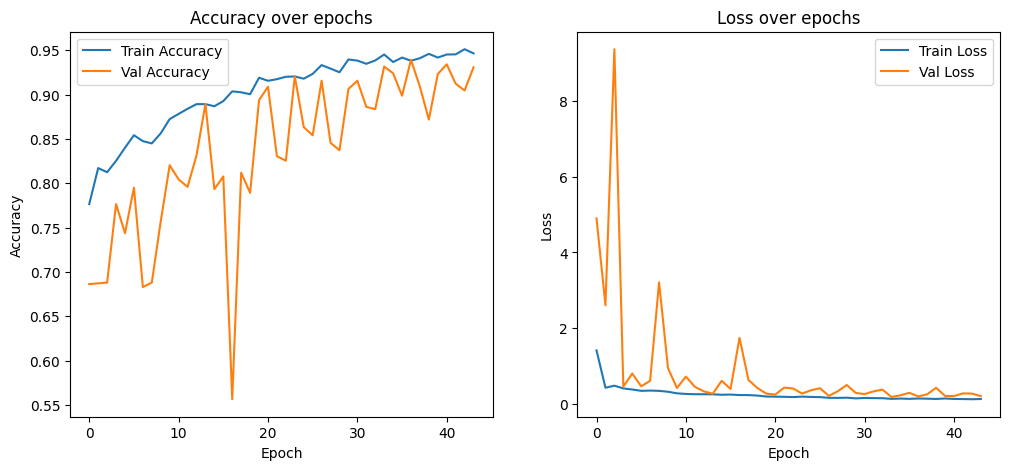

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Explanation: Based on results, the Convolutional Neural Network (CNN) is performing excellently and has successfully fixed the severe overfitting problem (refer on Activity 2 about ANN). The Accuracy over epochs plot shows both the training and validation accuracy lines are high (above 90%) and moving together, indicating the model is generalizing well to new images. This success is reinforced by the Loss over epochs plot, where both the training and validation loss lines quickly drop to a very low value and remain stable, meaning the model is making minimal errors on both datasets. Finally, the remarkable ROC-AUC score of 0.98 confirms that the CNN is highly effective at distinguishing between the two classes. Collectively, these metrics demonstrate that the CNN is a robust and reliable classifier.

# **STEP 5: PERFORM PREDICTIONS**

Once trained, the CNN model predicts the class of new breast tissue images. The model outputs probabilities for each class, which can be interpreted as the likelihood of the tissue being benign or malignant. Predictions can be visualized alongside the images to provide intuitive feedback on model performance.

---



**Generating Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


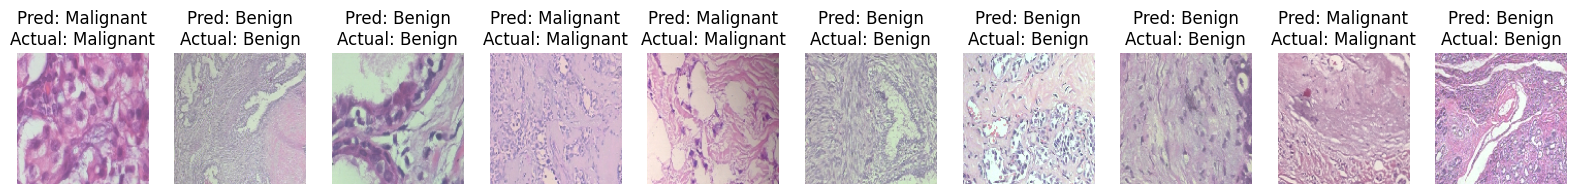

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)
class_names = ["Benign", "Malignant"]

plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = y_test[idx]

    pred_prob = model.predict(img[np.newaxis, ...])[0][0]
    pred_label = 1 if pred_prob >= 0.5 else 0

    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred_label]}\nActual: {class_names[true_label]}")
    plt.axis('off')

plt.show()


# **STEP 6: MODEL EVALUATION**

Evaluation measures how well the CNN performs on unseen data. Metrics such as accuracy, precision, recall, F1-score, confusion matrix, and ROC AUC are used to quantify performance. Visualizations such as ROC curves and confusion matrix heatmaps help identify strengths and weaknesses of the model and ensure it generalizes well to new images.

---



**Confusion Matrix** - shows the number of correct and incorrect predictions for each class.

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step


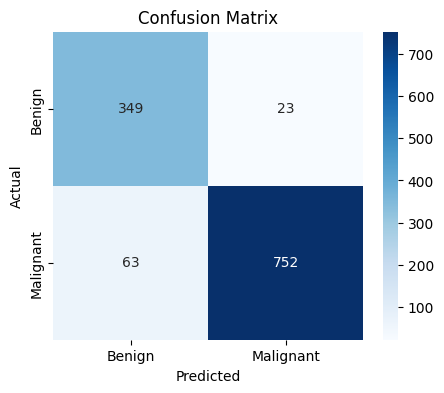

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Classification Report** - gives precision, recall, F1-score, and support for each class

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred, target_names=["Benign","Malignant"])
print("Classification Report:\n", cr)


Classification Report:
               precision    recall  f1-score   support

      Benign       0.85      0.94      0.89       372
   Malignant       0.97      0.92      0.95       815

    accuracy                           0.93      1187
   macro avg       0.91      0.93      0.92      1187
weighted avg       0.93      0.93      0.93      1187



**ROC AUC Score** - measures how well the model distinguishes between classes, with 1 being perfect separation.

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.9782917738637114


**ROC Curve** - plots True Positive Rate vs False Positive Rate across different thresholds to visualize model performance.

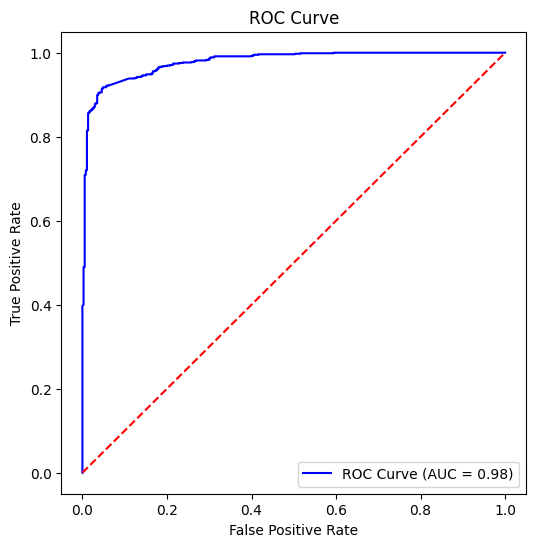

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Explanation: The model's overall effectiveness is quantified by the Area Under the Curve (AUC), which is an outstanding 0.98. This value indicates that there is a 98% chance that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance, signifying that the CNN is highly accurate and well-generalized in distinguishing between the two classes.

# **STEP 7: DEPLOYMENT**

For deployment, the trained CNN can be converted to TensorFlow Lite to run on low-resource devices while maintaining high prediction accuracy. The model is tested on sample images to validate its functionality in real-world scenarios. Deployment ensures the CNN can be integrated into applications to assist healthcare professionals in early breast cancer detection.

---



**Convert Keras Model to TensorFlow Lite**

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpgb006pe6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133905472471696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472472464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472474384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133909802632016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472471888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472473424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472474000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472474192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472475920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133905472476112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13390547247534

**Test the TensorFlow Lite Model**

In [ ]:
interpreter = tf.lite.Interpreter(model_path="cnn_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_image = X_test[0][np.newaxis, ...].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print("Predicted probability (TFLite):", output[0][0])
print("Actual label:", y_test[0])


Predicted probability (TFLite): 0.9983566
Actual label: 1


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


**Integration into Applications**


*   Deploy the .tflite CNN model into mobile, web, or embedded applications.

*   Use frameworks like TensorFlow Lite for Mobile, Edge devices, or Python APIs to integrate and run real-time predictions on new breast tissue images.

*   Ensure preprocessing (resizing, normalization) matches training preprocessing for consistent results.




# **STEP 8: MONITORING**

Monitoring ensures that the deployed CNN model continues to perform accurately over time. It involves tracking metrics such as prediction accuracy, false positives, and false negatives on new incoming data. Continuous monitoring helps detect performance drift due to changes in image quality, patient demographics, or acquisition techniques. By regularly reviewing logs and retraining the model if necessary, monitoring maintains the reliability and clinical utility of the CNN-based breast tissue classification system.

---



# **IMPORTANT NOTE:**

The significant overfitting problem observed in the initial Artificial Neural Network (ANN) in Activity 2 has been successfully addressed by transitioning to a Convolutional Neural Network (CNN) architecture. The original model suffered from a large gap between training and validation performance (high accuracy/low loss on training, but low/volatile accuracy/high loss on validation), indicating memorization. The CNN, designed specifically for image data, successfully mitigated this issue, as shown by the validation and training metrics tracking closely at high levels (accuracy over 90% and low loss) across the epochs. Furthermore, the outstanding Area Under the Curve (AUC) of 0.98 confirms that the CNN is now a robust, high-performing model that effectively generalizes to unseen images, solving the core reliability issue of the previous network.

---

